In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                 
from PIL import Image
import time
from keras.models import load_model
def cargaImagen(ruta):
    imagen = cv2.imread(ruta)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    return imagen

def dibujarImagen(imagen, title=''):
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title(title)
    ax1.imshow(imagen)

Using TensorFlow backend.


In [2]:
def dameCaras(imagen):
    copiaImagen = np.copy(imagen)
    gray = cv2.cvtColor(copiaImagen, cv2.COLOR_RGB2GRAY) 
    clasificadorCaras = cv2.CascadeClassifier('Detectores/haarcascade_frontalface_default.xml')
    caras = clasificadorCaras.detectMultiScale(gray, 1.2,4)
    return caras 

def pintarCaras(imagen, caras=None, plot=True):
    if caras is None:
        faces = dameCaras(imagen)
    imagenConCaras = np.copy(imagen) 
    for (x,y,w,h) in caras:
        cv2.rectangle(imagenConCaras, (x,y), (x+w,y+h), (255,0,0), 3)
        
    if plot is True:
        dibujarImagen(imagenConCaras)
    else:
        return imagenConCaras

def  pintarPuntosClave(imagen, informacionImagen):
    
    
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (cara, keypoints) in informacionImagen:
        for (x,y) in keypoints:ax1.scatter(x, y, marker='o', c='c', s=10)
   

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(imagen)

Caras detectadas: 4


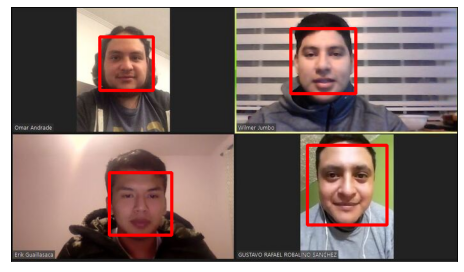

In [3]:
imagen = cargaImagen('imagenes/images.jpg')
caras = dameCaras(imagen)
print("Caras detectadas: {}".format(len(caras)))
pintarCaras(imagen, caras)

In [4]:
from utils import *
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
shape = (96,96)
modelo = Sequential()
modelo.add(Convolution2D(16,(2,2),padding='same',input_shape=(96,96, 1), activation='relu'))
modelo.add(MaxPooling2D(pool_size=3, data_format="channels_first"))

modelo.add(Convolution2D(32,(3,3),padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=3))
modelo.add(Dropout(0.2))

modelo.add(Convolution2D(64,(3,3),padding='same',activation='relu'))
modelo.add(MaxPooling2D(pool_size=3))
modelo.add(Dropout(0.2))

modelo.add(Convolution2D(128,(3,3),padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=3))
modelo.add(Dropout(0.2))

modelo.add(Flatten())
modelo.add(Dense(256,activation='relu'))
modelo.add(Dropout(0.2))

modelo.add(Dense(30))
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 32, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 32, 32)        1472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 3, 64)        

In [6]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, History  
iteraciones = 50
histo = History()
def compilarModelo(modelo, iteraciones):
    
    ruta = 'model.hdf5'
    modelo.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=ruta, 
                                   verbose=1, save_best_only=True)
    hist = modelo.fit(X_train, y_train, validation_split=0.2,
              epochs=iteraciones, batch_size=20, callbacks=[checkpointer, histo], verbose=1)
    
    modelo.save(ruta)
    
    return hist
entrenarModelo = False

if entrenarModelo is False:
    hist = compilarModelo(modelo, iteraciones) 
else:
    modelo.load_weights('model.hdf5')

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0193 - accuracy: 0.4936 - val_loss: 0.0187 - val_accuracy: 0.6963

Epoch 00001: val_loss improved from inf to 0.01873, saving model to model.hdf5
Epoch 2/50
1712/1712 [==============================] - 18s 10ms/step - loss: 0.0069 - accuracy: 0.6402 - val_loss: 0.0071 - val_accuracy: 0.6963

Epoch 00002: val_loss improved from 0.01873 to 0.00705, saving model to model.hdf5
Epoch 3/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0060 - accuracy: 0.6560 - val_loss: 0.0074 - val_accuracy: 0.6963

Epoch 00003: val_loss did not improve from 0.00705
Epoch 4/50
1712/1712 [==============================] - 18s 10ms/step - loss: 0.0058 - accuracy: 0.6758 - val_loss: 0.0051 - val_accuracy: 0.6963

Epoch 00004: val_loss improved from 0.00705 to 0.00508, saving model to model.hdf5
Epoch 5/50
1712/1712 [==============================] - 18s 11ms/step

1712/1712 [==============================] - 25s 15ms/step - loss: 0.0021 - accuracy: 0.7325 - val_loss: 0.0018 - val_accuracy: 0.7290

Epoch 00038: val_loss did not improve from 0.00176
Epoch 39/50
1712/1712 [==============================] - 28s 16ms/step - loss: 0.0020 - accuracy: 0.7424 - val_loss: 0.0017 - val_accuracy: 0.7687

Epoch 00039: val_loss improved from 0.00176 to 0.00166, saving model to model.hdf5
Epoch 40/50
1712/1712 [==============================] - 26s 15ms/step - loss: 0.0020 - accuracy: 0.7535 - val_loss: 0.0016 - val_accuracy: 0.7313

Epoch 00040: val_loss improved from 0.00166 to 0.00164, saving model to model.hdf5
Epoch 41/50
1712/1712 [==============================] - 27s 15ms/step - loss: 0.0019 - accuracy: 0.7494 - val_loss: 0.0016 - val_accuracy: 0.7407

Epoch 00041: val_loss improved from 0.00164 to 0.00161, saving model to model.hdf5
Epoch 42/50
1712/1712 [==============================] - 24s 14ms/step - loss: 0.0019 - accuracy: 0.7535 - val_loss: 0.0

In [7]:
def obtenerPuntosClave(imagen, caras=None):
    resultado = []
    if caras is None:
        caras = get_faces(imagen)
    carasForma = (96, 96)
    copiaImagen = np.copy(imagen)
    for (x,y,w,h) in caras:
        cara = copiaImagen[y:y+h,x:x+w]
        caraGris = cv2.cvtColor(cara, cv2.COLOR_BGR2GRAY)
        caraGrisRedimensionar = cv2.resize(caraGris, carasForma) / 255
        inputs = np.expand_dims(np.expand_dims(caraGrisRedimensionar, axis=-1), axis=0)                   
        puntosClavePrediccion = modelo.predict(inputs)
        puntosClavePrediccion = np.squeeze(puntosClavePrediccion)
        
        puntosClave = []        
        for idx in range(0, len(puntosClavePrediccion), 2):
            x_scale_factor = cara.shape[0]/carasForma[0] 
            y_scale_factor = cara.shape[1]/carasForma[1] 

            x_center_left_offset = puntosClavePrediccion[idx] * carasForma[0]/2 + carasForma[0]/2 
            y_center_left_offset = puntosClavePrediccion[idx + 1] * carasForma[1]/2 + carasForma[1]/2
            
            x_center = int(x + (x_scale_factor * x_center_left_offset))
            y_center = int(y + (y_scale_factor * y_center_left_offset))

            puntosClave.append([x_center, y_center])
        
        resultado.append([(x,y,w,h), puntosClave])
    return resultado

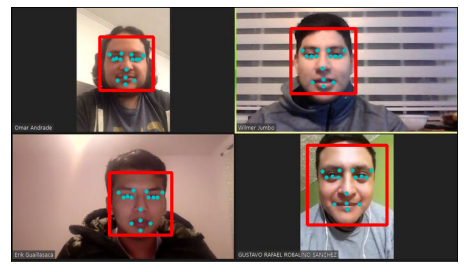

In [8]:
def mostrarImagenCaracteristicas(image_path):
    imagen = cargaImagen(image_path)
    caras = dameCaras(imagen)
    puntosClave = obtenerPuntosClave(imagen, caras)
    imagenConCaras = pintarCaras(imagen, caras ,plot=False)
    pintarPuntosClave(imagenConCaras, puntosClave)

mostrarImagenCaracteristicas('imagenes/images.jpg')

C:\Users\santi\anaconda3\envs\PIA\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


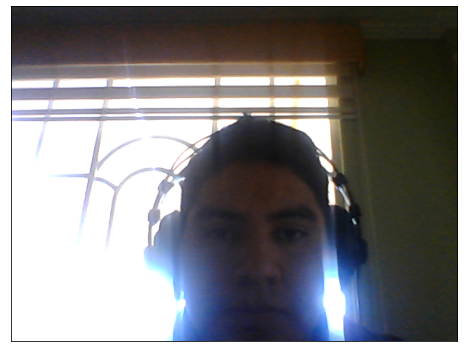

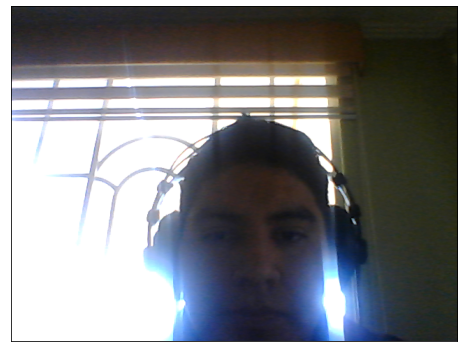

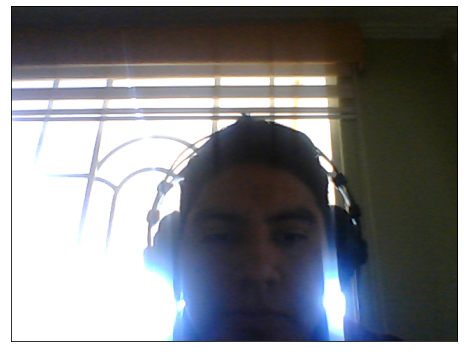

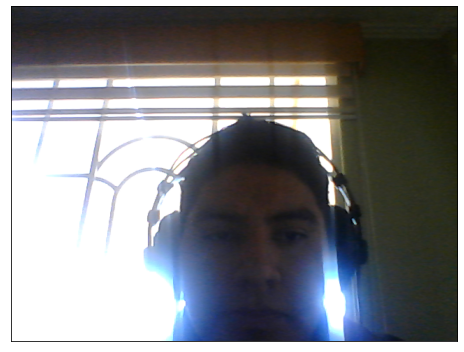

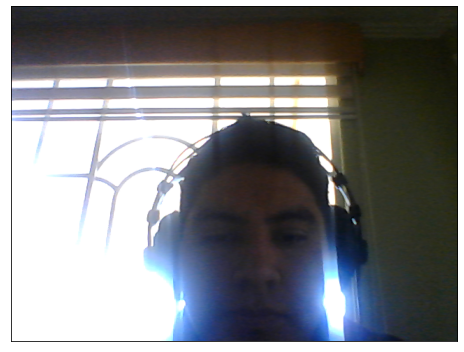

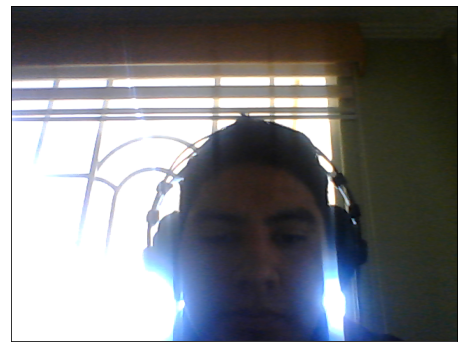

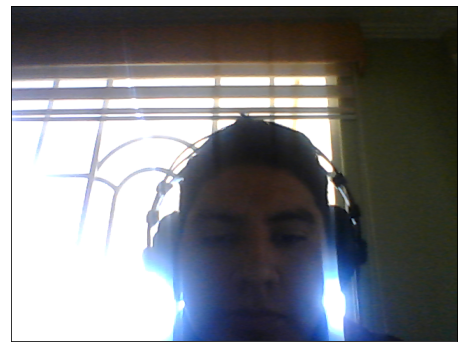

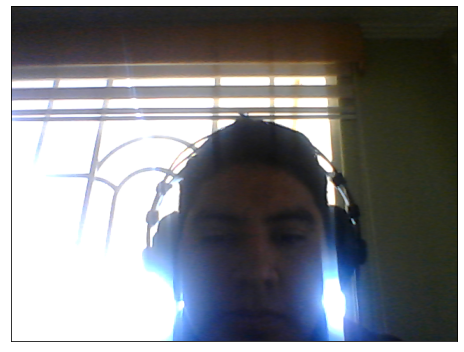

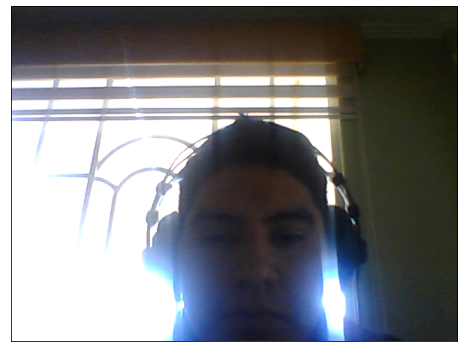

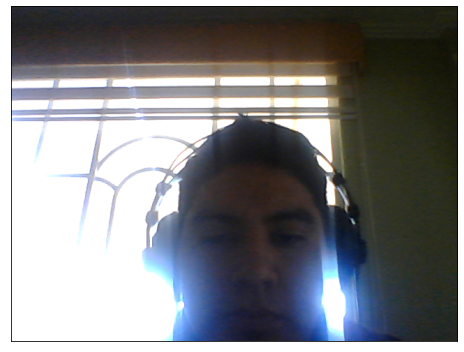

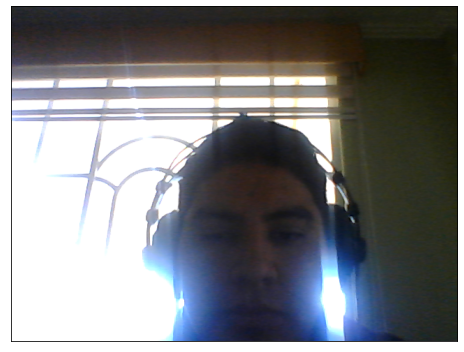

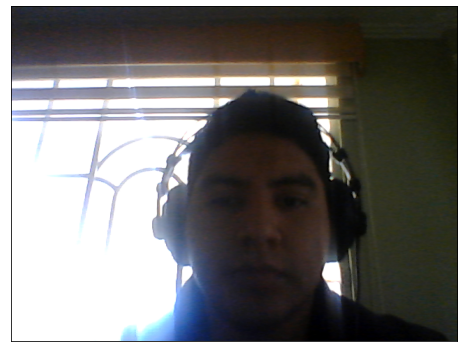

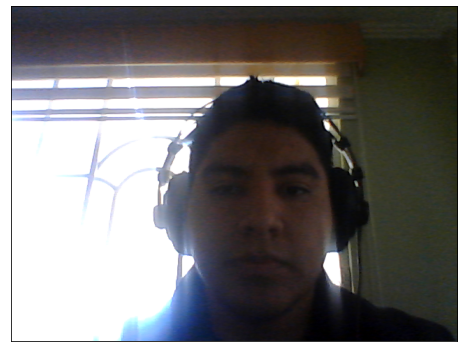

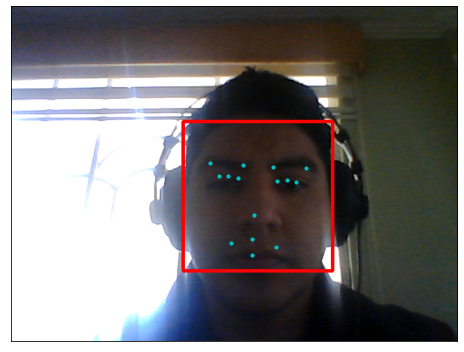

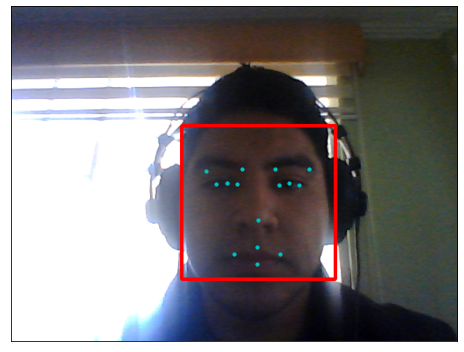

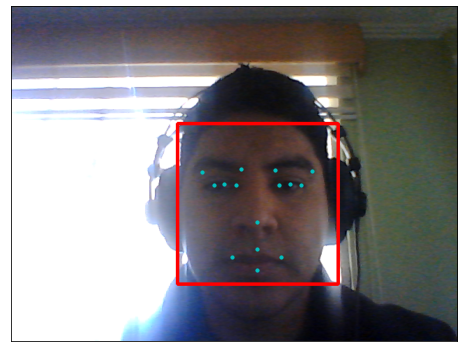

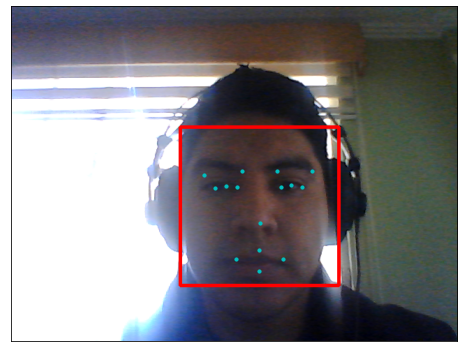

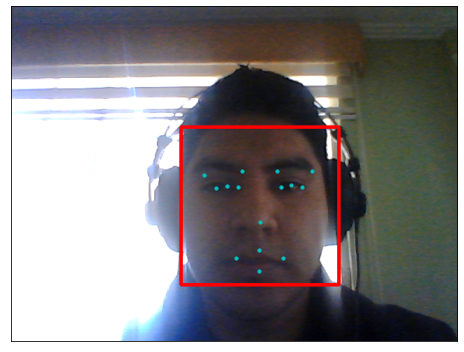

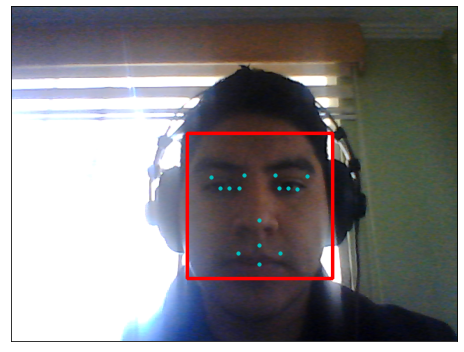

In [ ]:
import cv2
import time 
from keras.models import load_model
def laptop_camera_go():
    cv2.namedWindow("Deteccion facial")
    vc = cv2.VideoCapture(1)
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    while rval:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        caras = dameCaras(frame)
        puntosClave = obtenerPuntosClave(frame, caras)
        imagenConCaras = pintarCaras(frame, caras ,plot=False)
        pintarPuntosClave(imagenConCaras, puntosClave)
        cv2.imshow("Deteccion facial activada", frame)
        key = cv2.waitKey(20)
        if key > 0: 
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        time.sleep(0.05)            
        rval, frame = vc.read()
laptop_camera_go()